<a href="https://colab.research.google.com/github/khaledwaleedsamir/optimize-and-deploy-DL-models/blob/mobilenet/MobileNet_10Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

### Define the model

In [ ]:
# Load the pre-trained MobileNet model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some of the top layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False
# Add custom classification layers for CIFAR-10 (10 classes)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)  # Multi-class classification (10 classes)

# Define the final model
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,534,858 (13.48 MB)

 Trainable params: 2,700,746 (10.30 MB)

 Non-trainable params: 834,112 (3.18 MB)

### Importing CIFAR-10 Dataset and pre-processing pipeline


In [ ]:
# Load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(f"Original Train set: {x_train.shape}")
print(f"Original Test set: {x_test.shape}")

Original Train set: (50000, 32, 32, 3)
Original Test set: (10000, 32, 32, 3)


In [ ]:
# Reserve 5000 samples from the training set for validation
x_train, x_dev = x_train[:45000], x_train[45000:]
y_train, y_dev = y_train[:45000], y_train[45000:]

print(f"Train set: {x_train.shape}")
print(f"Dev set: {x_dev.shape}")
print(f"Test set: {x_test.shape}")

Train set: (45000, 32, 32, 3)
Dev set: (5000, 32, 32, 3)
Test set: (10000, 32, 32, 3)


In [ ]:
# Define batch size
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE  # Optimizes performance

# Function to resize and normalize images
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize dynamically
    image = preprocess_input(image)  # Normalize for MobileNet
    return image, label

# Convert datasets to tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dev_dataset = tf.data.Dataset.from_tensor_slices((x_dev, y_dev))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Apply preprocessing and batching
train_dataset = (
    train_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

dev_dataset = (
    dev_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_dataset = (
    test_dataset
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Print dataset structure
print(train_dataset)
print(dev_dataset)
print(test_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>


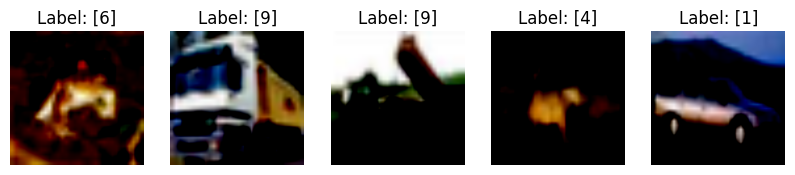

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images
sample_images, sample_labels = next(iter(train_dataset.take(1)))

# Convert images to numpy for display
sample_images = sample_images.numpy()

# Plot 5 sample images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Label: {sample_labels[i].numpy()}")
    plt.axis("off")

plt.show()

### Training the model

In [ ]:
# Train the model with a learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5, patience=3,
    min_lr=1e-6
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,                 # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore the model from the best epoch
    verbose=1
)

# Train for more epochs (with data augmentation if needed)
history = model.fit(train_dataset, validation_data=dev_dataset, epochs=20, callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 88s 102ms/step - accuracy: 0.6005 - loss: 1.2975 - val_accuracy: 0.8332 - val_loss: 0.5611 - learning_rate: 0.0010
Epoch 2/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 62s 84ms/step - accuracy: 0.8702 - loss: 0.4434 - val_accuracy: 0.8552 - val_loss: 0.4998 - learning_rate: 0.0010
Epoch 3/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - accuracy: 0.8991 - loss: 0.3492 - val_accuracy: 0.8454 - val_loss: 0.5485 - learning_rate: 0.0010
Epoch 4/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - accuracy: 0.9268 - loss: 0.2529 - val_accuracy: 0.8660 - val_loss: 0.5122 - learning_rate: 0.0010
Epoch 5/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.9431 - loss: 0.1973 - val_accuracy: 0.8890 - val_loss: 0.4204 - learning_rate: 0.0010
Epoch 6/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9433 - loss: 0.1892 - val_accuracy: 0.8904 - val_loss: 0.4357 - learning_rate: 0.0010
Epoch 7/20
704/704 ━━━━━━━━━━━━━━━━━━━━ 83s 84ms/step - accuracy: 0.9543 - 

KeyboardInterrupt: 

### Evaluating the model

In [ ]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 92ms/step - accuracy: 0.9386 - loss: 0.3718
Test Accuracy: 93.66%


In [ ]:
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Predict on test data
y_true = np.concatenate([y.numpy() for _, y in test_dataset])  # True labels
y_pred = model.predict(test_dataset)  # Predictions from the model

# Convert predictions to class labels (max probability as class prediction)
y_pred_classes = np.argmax(y_pred, axis=1).flatten()  # Get class with max probability for each sample

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_true, y_pred_classes, target_names=['airplane', 'automobile', 'bird', 'cat', 'deer',
                                                                         'dog', 'frog', 'horse', 'ship', 'truck'])
print("Classification Report:")
print(class_report)

157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step
Confusion Matrix:
[[952   1  13   1   2   0   3   6  19   3]
 [  4 983   0   0   0   0   0   0   3  10]
 [ 13   0 915  20  18  16   8   6   4   0]
 [  7   0  21 880  14  55  11   8   4   0]
 [  5   1  17  18 937   8   6   8   0   0]
 [  2   1  15  74  16 876   4  12   0   0]
 [  5   0  11  14   6   6 957   0   0   1]
 [  2   0   8   8   9  16   1 956   0   0]
 [ 16   3   5   2   2   1   0   0 965   6]
 [  3  27   2   6   0   2   0   5  10 945]]
Classification Report:
              precision    recall  f1-score   support

    airplane       0.94      0.95      0.95      1000
  automobile       0.97      0.98      0.98      1000
        bird       0.91      0.92      0.91      1000
         cat       0.86      0.88      0.87      1000
        deer       0.93      0.94      0.94      1000
         dog       0.89      0.88      0.88      1000
        frog       0.97      0.96      0.96      1000
       horse       0.96      0.96      0.96      100

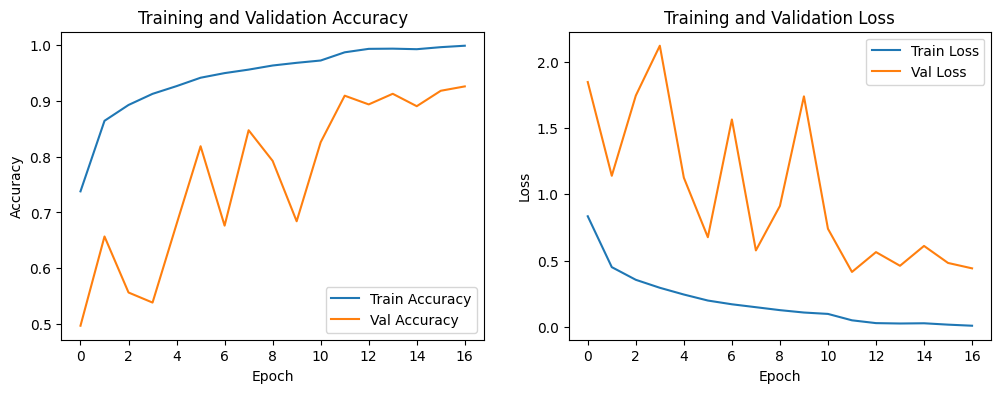

In [ ]:
# Plot training and validation curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_training_curves(history)

### Saving the model to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model_save_path = "/content/drive/My Drive/saved_models/mobileNet-CIFAR10-93.h5"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/My Drive/saved_models/mobileNet-CIFAR10-93.h5
